In [11]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.datasets as ds

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, StandardScaler, MaxAbsScaler, QuantileTransformer, FunctionTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

%matplotlib inline

In [24]:
# Data reading

data = ds.fetch_openml('credit-g', as_frame=True).frame

display(data.sample(10))

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
159,no checking,6.0,critical/other existing credit,radio/tv,1898.0,no known savings,1<=X<4,1.0,male single,none,2.0,real estate,34.0,none,own,2.0,unskilled resident,2.0,none,yes,good
16,no checking,24.0,critical/other existing credit,radio/tv,2424.0,no known savings,>=7,4.0,male single,none,4.0,life insurance,53.0,none,own,2.0,skilled,1.0,none,yes,good
789,<0,40.0,critical/other existing credit,education,5998.0,<100,1<=X<4,4.0,male single,none,3.0,no known property,27.0,bank,own,1.0,skilled,1.0,yes,yes,bad
756,>=200,6.0,critical/other existing credit,new car,1299.0,<100,1<=X<4,1.0,male single,none,1.0,real estate,74.0,none,own,3.0,unemp/unskilled non res,2.0,none,no,good
79,0<=X<200,30.0,existing paid,furniture/equipment,3832.0,<100,<1,2.0,male mar/wid,none,1.0,life insurance,22.0,none,own,1.0,skilled,1.0,none,yes,good
828,<0,36.0,existing paid,used car,8335.0,no known savings,>=7,3.0,male single,none,4.0,no known property,47.0,none,for free,1.0,skilled,1.0,none,yes,bad
399,no checking,24.0,critical/other existing credit,radio/tv,1516.0,>=1000,1<=X<4,4.0,female div/dep/mar,none,1.0,real estate,43.0,none,own,2.0,unskilled resident,1.0,none,yes,good
389,no checking,9.0,existing paid,business,1449.0,<100,4<=X<7,3.0,female div/dep/mar,none,2.0,car,27.0,none,own,2.0,skilled,1.0,none,yes,good
213,>=200,30.0,delayed previously,business,1908.0,<100,>=7,4.0,male single,none,4.0,real estate,66.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,bad
862,<0,24.0,existing paid,radio/tv,2439.0,<100,<1,4.0,female div/dep/mar,none,4.0,real estate,35.0,none,own,1.0,skilled,1.0,yes,yes,bad


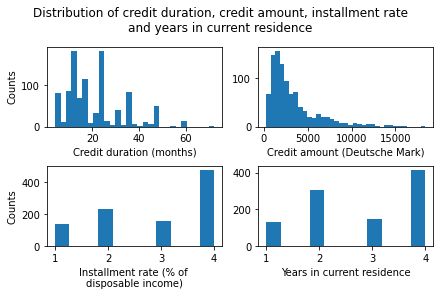

In [13]:
# Distribution of the first four non-categorical features 
fig, ax = plt.subplots(2, 2, constrained_layout=True)

fig.suptitle('Distribution of credit duration, credit amount, installment rate\nand years in current residence')

ax[0, 0].hist(data['duration'], bins='auto')
ax[0, 0].set_xlabel('Credit duration (months)')
ax[0, 0].set_ylabel('Counts')

ax[0, 1].hist(data['credit_amount'], bins='auto')
ax[0, 1].set_xlabel('Credit amount (Deutsche Mark)')

ax[1, 0].hist(data['installment_commitment'], bins='auto')
ax[1, 0].set_xlabel('Installment rate (% of \ndisposable income)')
ax[1, 0].set_ylabel('Counts')

ax[1, 1].hist(data['residence_since'], bins='auto')
ax[1, 1].set_xlabel('Years in current residence')

non_cat_cols = ['duration', 'credit_amount', 'installment_commitment', 'residence_since']

plt.show()

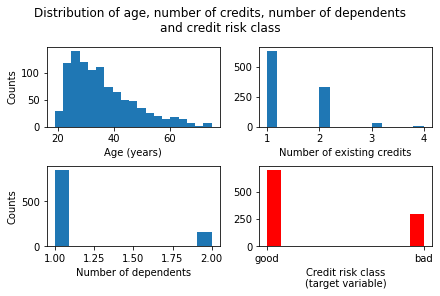

In [14]:
# Distribution of the remaining non-categorical features as well as the target 
fig, ax = plt.subplots(2, 2, constrained_layout=True)

fig.suptitle('Distribution of age, number of credits, number of dependents\nand credit risk class')

ax[0, 0].hist(data['age'], bins='auto')
ax[0, 0].set_xlabel('Age (years)')
ax[0, 0].set_ylabel('Counts')

ax[0, 1].hist(data['existing_credits'], bins='auto')
ax[0, 1].set_xlabel('Number of existing credits')

ax[1, 0].hist(data['num_dependents'], bins='auto')
ax[1, 0].set_xlabel('Number of dependents')
ax[1, 0].set_ylabel('Counts')

ax[1, 1].hist(data['class'], color='r', bins='auto')
ax[1, 1].set_xlabel('Credit risk class\n(target variable)')

non_cat_cols.extend(['age', 'existing_credits', 'num_dependents'])
cat_cols = [col for col in data.columns if col not in non_cat_cols and col != 'class']

plt.show()

/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sk

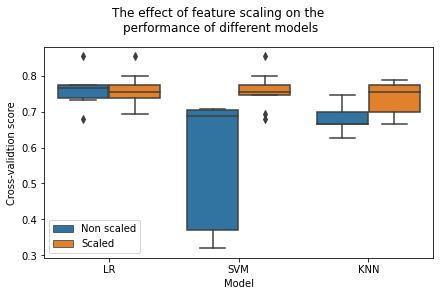

In [22]:
# Train-test-validation split
X = data.loc[:, data.columns != 'class']
y = data['class']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=0)

cv = 10

# Initializing variables for storing the score data
score_data = {'Model': [], 'Preprocessing': [], 'Scores': []}
model_data = [('LR', LogisticRegression()), ('SVM', LinearSVC()), ('KNN', KNeighborsClassifier())]

# Perform only the required preprocessing of categorical features
X_train_val_trans = pd.get_dummies(X_train_val, columns=cat_cols)

warnings.filterwarnings('ignore') # Ignoring warning due to lack of scaling

for name, model in model_data:
    score_data['Model'] += [name] * cv
    score_data['Preprocessing'] += ['Non scaled'] * cv
    score_data['Scores'].extend(cross_val_score(model, X_train_val_trans, y_train_val, cv=cv))
    
warnings.filterwarnings('default')

# Creating main column transformer and fitting with pipelines
col_trans = ColumnTransformer([
    ('cont', RobustScaler(), ['duration', 'credit_amount', 'age']),
    ('disc', MinMaxScaler(), ['installment_commitment', 'residence_since', 'existing_credits', 'num_dependents']),
    ('cat', OneHotEncoder(), cat_cols)
])

for name, model in model_data:
    score_data['Model'] += [name] * cv
    score_data['Preprocessing'] += ['Scaled'] * cv
    score_data['Scores'].extend(cross_val_score(make_pipeline(col_trans, model), X_train_val, y_train_val, cv=cv))

# Box plots of the models' performance 
fig, ax = plt.subplots(constrained_layout=True)

fig.suptitle('The effect of feature scaling on the \nperformance of different models')
ax.set_xlabel('Model')
ax.set_ylabel('Cross-validtion score')

sns.boxplot(x=score_data['Model'], y=score_data['Scores'], hue=score_data['Preprocessing'], ax=ax)

ax.legend()

plt.show()

In [16]:
# Create pipeline and parameter grid (leaving out transformer tunning for simplicity of visualization)
pipe = Pipeline([
    ('trans', col_trans),
    ('clf', LogisticRegression())
])

param_grid = [
    {'clf': [LogisticRegression(penalty='elasticnet', solver='saga')],
     'clf__C': np.logspace(-2, 3, 6),
     'clf__l1_ratio': np.linspace(0, 1, 6)},
    {'clf': [LinearSVC()],
     'clf__C': np.logspace(-2, 3, 6),
     'clf__loss': ['hinge', 'squared_hinge']},
    {'clf': [KNeighborsClassifier()],
     'clf__n_neighbors': np.arange(1, 10),
     'clf__weights': ['uniform', 'distance']}
]

# Perform grid search
grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train_val, y_train_val)

print('Best validation score: ', grid.best_score_,
      '\nBest parameters: ', grid.best_params_,
      '\nTest score of the best parameters: ', grid.score(X_test, y_test))

/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-m

Best validation score:  0.7653333333333333 
Best parameters:  {'clf': LinearSVC(C=0.1), 'clf__C': 0.1, 'clf__loss': 'squared_hinge'} 
Test score of the best parameters:  0.732


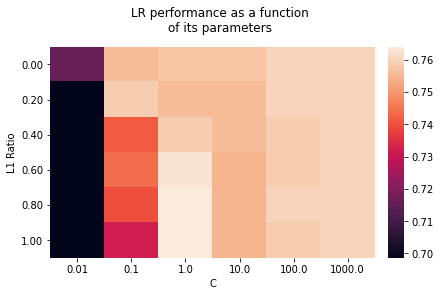

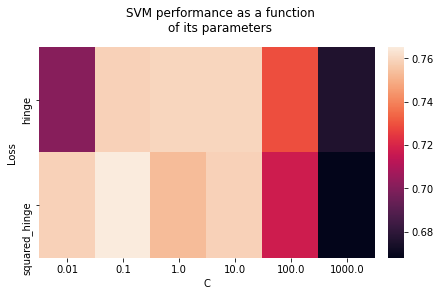

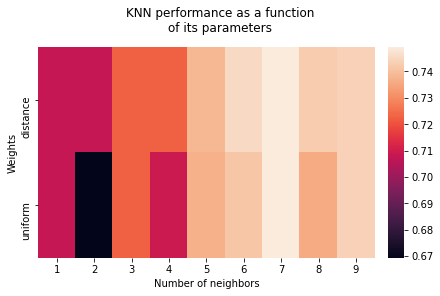

In [17]:
# Transforming the CV results into a Dataframe for a simpler handling
cv_res = pd.DataFrame(grid.cv_results_)

# Visualizing the performance of LR as a function of its parameters
fig1, ax1 = plt.subplots(constrained_layout=True)
fig1.suptitle('LR performance as a function\nof its parameters')

lr_rows = cv_res.loc[cv_res['param_clf'].apply(lambda x: isinstance(x, LogisticRegression))]

sns.heatmap(lr_rows.pivot('param_clf__l1_ratio', 'param_clf__C', 'mean_test_score'), ax=ax1)

ax1.set_xlabel('C')
ax1.set_ylabel('L1 Ratio')
ax1.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax1.get_yticklabels()]) 

# Visualizing the performance of SVM as a function of its parameters
fig2, ax2 = plt.subplots(1, constrained_layout=True)
fig2.suptitle('SVM performance as a function\nof its parameters')

svm_rows = cv_res.loc[cv_res['param_clf'].apply(lambda x: isinstance(x, LinearSVC))]

sns.heatmap(svm_rows.pivot('param_clf__loss', 'param_clf__C', 'mean_test_score'), ax=ax2)

ax2.set_xlabel('C')
ax2.set_ylabel('Loss')

# Visualizing the performance of KNN as a function of its parameters
fig3, ax3 = plt.subplots(1, constrained_layout=True)
fig3.suptitle('KNN performance as a function\nof its parameters')

knn_rows = cv_res.loc[cv_res['param_clf'].apply(lambda x: isinstance(x, KNeighborsClassifier))]

sns.heatmap(knn_rows.pivot('param_clf__weights', 'param_clf__n_neighbors', 'mean_test_score'), ax=ax3)

ax3.set_xlabel('Number of neighbors')
ax3.set_ylabel('Weights')

plt.show()

In [18]:
# Assessing the effect in the results of using unstratified k-fold and changing the random seeds
params_dict = {'Strategy': ['Stratified K-Fold'], 'Best Parameters': [grid.best_params_], 'Test Score': [grid.score(X_test, y_test)]}

# K-Fold with shuffling (fixed seed)
k_fold_shuffle1_grid = GridSearchCV(pipe, param_grid, cv=KFold(random_state=0, shuffle=True))
k_fold_shuffle1_grid.fit(X_train_val, y_train_val)

params_dict['Strategy'].append('K-Fold with Shuffling (seed = 0)')
params_dict['Best Parameters'].append(k_fold_shuffle1_grid.best_params_)
params_dict['Test Score'].append(k_fold_shuffle1_grid.score(X_test, y_test))

# K-Fold with shuffling (changing seed)
k_fold_shuffle2_grid = GridSearchCV(pipe, param_grid, cv=KFold(random_state=1, shuffle=True))
k_fold_shuffle2_grid.fit(X_train_val, y_train_val)

params_dict['Strategy'].append('K-Fold with Shuffling (seed = 1)')
params_dict['Best Parameters'].append(k_fold_shuffle2_grid.best_params_)
params_dict['Test Score'].append(k_fold_shuffle2_grid.score(X_test, y_test))
    
# Print results
results = pd.DataFrame(params_dict)

display(results.set_index('Strategy'))

/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-ml/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/luisungaro/.virtualenvs/applied-m

,Best Parameters,Test Score
Strategy,,
Stratified K-Fold,"{'clf': LinearSVC(loss='hinge'), 'clf__C': 0.1, 'clf__loss': 'squared_hinge'}",0.732
K-Fold with Shuffling (seed = 0),"{'clf': LinearSVC(loss='hinge'), 'clf__C': 1.0, 'clf__loss': 'hinge'}",0.732
K-Fold with Shuffling (seed = 1),"{'clf': LogisticRegression(C=0.1, l1_ratio=0.0, penalty='elasticnet', solver='saga'), 'clf__C': 0.1, 'clf__l1_ratio': 0.0}",0.752


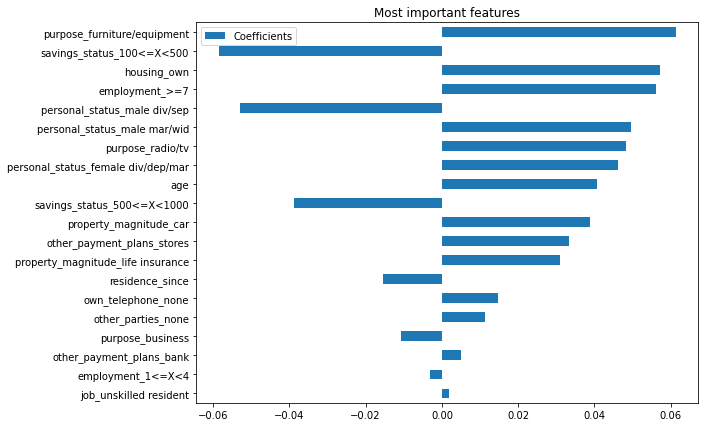

In [19]:
# Feature importance
feature_names = []

for trans in grid.best_estimator_.named_steps['trans'].transformers_:
    if trans[0] == 'cat':
        feature_names.extend(trans[1].get_feature_names(input_features=trans[2]))
    else:
        feature_names.extend(trans[2])
        
coefs = pd.DataFrame(
    np.ravel(grid.best_estimator_.named_steps['clf'].coef_),
    columns=['Coefficients'], index=feature_names
)

coefs.reindex(coefs.abs().sort_values(by=['Coefficients']).index).head(20).plot(kind='barh', figsize=(9, 7))
plt.title('Most important features')

plt.show()